# Week 3 : Reconstruction of Z boson using 2e2mu decay mode

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import vector
import mplhep as hep

# Register vector to use with awkward arrays
vector.register_awkward()

# Set CMS style for the plots
plt.style.use(hep.style.CMS)

def reco_Z_to_2el2mu(events):
    """Reconstruct Z bosons from two electrons and two muons"""

    # Apply the selection to filter events with at least 2 electrons and 2 muons
    events = selection_2el2mu(events)

    # Reconstruct Z bosons using the four-momentum components of electrons and muons
    z1_mass, z2_mass = compute_z_masses_2el2mu(
        events.Electron_pt, events.Electron_eta, events.Electron_phi, events.Electron_mass,
        events.Muon_pt, events.Muon_eta, events.Muon_phi, events.Muon_mass
    )

    # Filter for events that satisfy the Z mass window
    z1_mask = (z1_mass > 40) & (z1_mass < 120)
    z2_mask = (z2_mass > 12) & (z2_mass < 120)

    # Mask events based on Z mass windows
    selected_z1_mass = z1_mass[z1_mask]
    selected_z2_mass = z2_mass[z2_mask]

    return selected_z1_mass, selected_z2_mass

def selection_2el2mu(events):
    """Select events with at least two electrons and two muons"""

    # Mask for electrons: at least 2 electrons with |eta| < 2.5
    electron_mask = (events["nElectron"] >= 2) & (ak.all(np.abs(events["Electron_eta"]) < 2.5, axis=1))

    # Mask for muons: at least 2 muons with |eta| < 2.4
    muon_mask = (events["nMuon"] >= 2) & (ak.all(np.abs(events["Muon_eta"]) < 2.4, axis=1))

    # Combine the electron and muon masks
    combined_mask = electron_mask & muon_mask

    # Apply the combined mask to select events
    selected_events = events[combined_mask]

    return selected_events

# Define a function to compute the Z masses from electron and muon four-momenta
def compute_z_masses_2el2mu(electron_pt, electron_eta, electron_phi, electron_mass,
                            muon_pt, muon_eta, muon_phi, muon_mass):
    
    # Create Lorentz vectors for electrons and muons using awkward and vector
    electron_p4 = ak.zip({
        "pt": electron_pt,
        "eta": electron_eta,
        "phi": electron_phi,
        "mass": electron_mass
    }, with_name="PtEtaPhiMLorentzVector")
    
    muon_p4 = ak.zip({
        "pt": muon_pt,
        "eta": muon_eta,
        "phi": muon_phi,
        "mass": muon_mass
    }, with_name="PtEtaPhiMLorentzVector")

    # Convert awkward arrays to vector.Array
    electron_vec = vector.awk(ak.Array(electron_p4))
    muon_vec = vector.awk(ak.Array(muon_p4))

    # Form Z candidates by adding the appropriate four-momenta
    z1 = electron_vec[:, 0] + electron_vec[:, 1]  # First Z candidate (from electrons)
    z2 = muon_vec[:, 0] + muon_vec[:, 1]          # Second Z candidate (from muons)

    # Compute invariant masses
    z1_mass = z1.mass
    z2_mass = z2.mass

    return z1_mass, z2_mass

def plot_z_mass(z_mass, x_label):
    # Create histogram bins
    bins = np.linspace(60, 120, 30)  # 30 Bins from 60 to 120 GeV

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))  # Width of 8 inches and height of 6 inches

    # Plot the Z mass histogram
    ax.hist(z_mass, bins=bins, histtype='stepfilled', color='blue', alpha=0.7, linewidth=2)

    # Add labels and title
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel('Number of Events', fontsize=14)

    # CMS-style text
    ax.text(0.05, 1.02, r'$\mathbf{CMS \ Open \ Data}$', transform=ax.transAxes, fontsize=14)
    ax.text(0.6, 1.02, r'$\sqrt{s} = 8 \ \mathrm{TeV}, L_{int} = 11.6 \ \mathrm{fb}^{-1}$', transform=ax.transAxes, fontsize=12)

    # Display the plot
    plt.grid(True)
    plt.show()



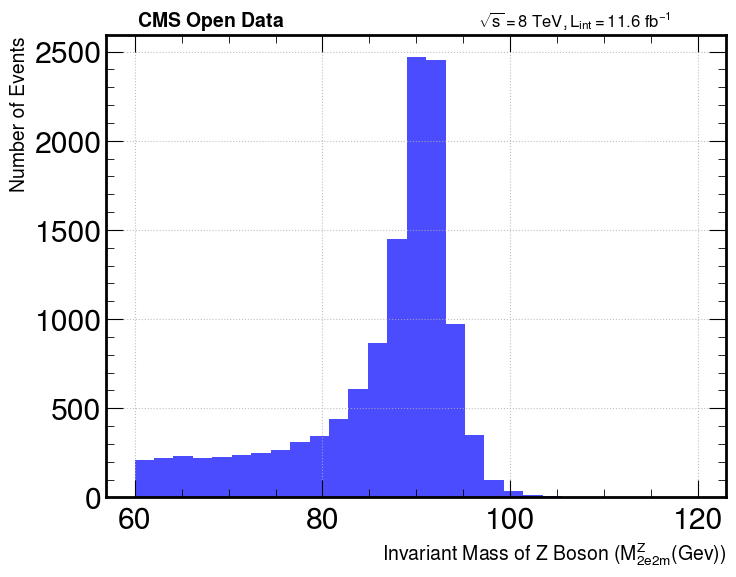

In [2]:
# Load data from ROOT file using uproot
file = uproot.open('/home/bhanda25/Phys323_fall2024/Root_files/SMHiggsToZZTo4L.root')
tree = file["Events"]
branches = tree.arrays(["nElectron", "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass",
                        "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass"], library="ak")

# Reconstruct Z bosons and retrieve invariant masses
z1_mass, z2_mass = reco_Z_to_2el2mu(branches)

# Combine both Z masses for plotting
all_z_masses = ak.concatenate([z1_mass, z2_mass])

# Convert awkward array to NumPy array for plotting
z_mass_np = ak.to_numpy(all_z_masses)

plot_z_mass(z_mass_np, "Invariant Mass of Z Boson ($M_{2e2m}^Z$(Gev))")

# Homework Assignment #3: Z Boson Mass Reconstruction for 4-Electron Decay

## Objective
To reconstruct the Z boson mass from events where the decay mode involves four electrons, and to perform an analysis similar to the provided code but tailored to this specific decay mode.

## Tasks

### 1. Data Preparation
- **Task 1.1**: Load a ROOT file that contains data for electron events. Identify relevant branches for electrons, such as `Electron_pt`, `Electron_eta`, `Electron_phi`, and `Electron_mass`.

### 2. Function Implementation
- **Task 2.1**: Implement a function `reco_Z_to_4e(events)` to reconstruct Z bosons from four electrons. This function should:
  - **Filter Events**: Select events with exactly four electrons using a selection function similar to `selection_2el2mu`, but adapted for four electrons. <div style="color: red">Add one selection condition on top of above mentioned condition for electron: Electron_pt > 7 </div>
  
  - **Compute Z Bosons**: Calculate the invariant mass of two Z boson candidates formed from the four electrons. This requires:
    - **Pairing Electrons**: Implement logic to pair the four electrons to form two Z boson candidates.
    - **Compute Masses**: Use the four-momentum of the paired electrons to compute the invariant masses of the Z bosons.

### 3. Histogram Plotting
- **Task 3.1**: Create a histogram of the invariant mass distribution of the Z bosons using the `plot_z_mass` function provided earlier. Ensure the plot uses CMS style.
- **Task 3.2**: Modify the `plot_z_mass` function if necessary to fit your data and plot the distribution of the reconstructed Z boson masses.

### 4. Analysis and Reporting
- **Task 4.1**: Analyze the distribution of Z boson masses. Look for any patterns or anomalies and compare the results to the expected mass window for Z bosons (typically around 91 GeV).
- **Task 4.2**: Write a brief report summarizing your findings, including the distribution of Z boson masses and any interesting observations. I recommend that you calculate the mean and standard deviation of the plot.

## Submission Guidelines
- Submit a Jupyter notebook or Python script in the similar format as the hw 1 with the following:
  - **Code**: Implementation of the `reco_Z_to_4e` function and any other modifications or additions to the provided code.
  - **Plots**: Histograms of the Z boson mass distribution, using CMS-style formatting.
  - **Report**: A brief written summary of your analysis and findings.

## Evaluation Criteria
- Correctness and functionality of the `reco_Z_to_4e` function.
- Accuracy of the Z boson mass reconstruction and histogram plotting.
- Quality of the analysis and clarity of the written report.

---

This assignment will help you apply your skills in particle physics event reconstruction and data analysis, reinforcing your understanding of invariant mass calculations and data visualization.

<div style="color: red; font-weight: bold;">
The due date for this assignment is September 27.
</div>
